In [1]:
#import 
import cv2
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt 
import numpy as np
import time
from PIL import Image
from torch.autograd import Variable

In [2]:
#Transform and load dataset
#Argument training_set by RandomResizedCrop, RandomHorizontalFlip
#Normalize data: [-1, 1]
transform_train = transforms.Compose([transforms.RandomResizedCrop(32),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

transform_val = transforms.Compose([transforms.Resize((32, 32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

train_set = datasets.ImageFolder(root='./Animals-Dataset/train', transform=transform_train)
val_set = datasets.ImageFolder(root='./Animals-Dataset/val', transform=transform_val)

batch_size = 32
train_load = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_load = torch.utils.data.DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)

print('Train_set:', len(train_set))
print('Validation_set:', len(val_set))

Train_set: 2400
Validation_set: 600


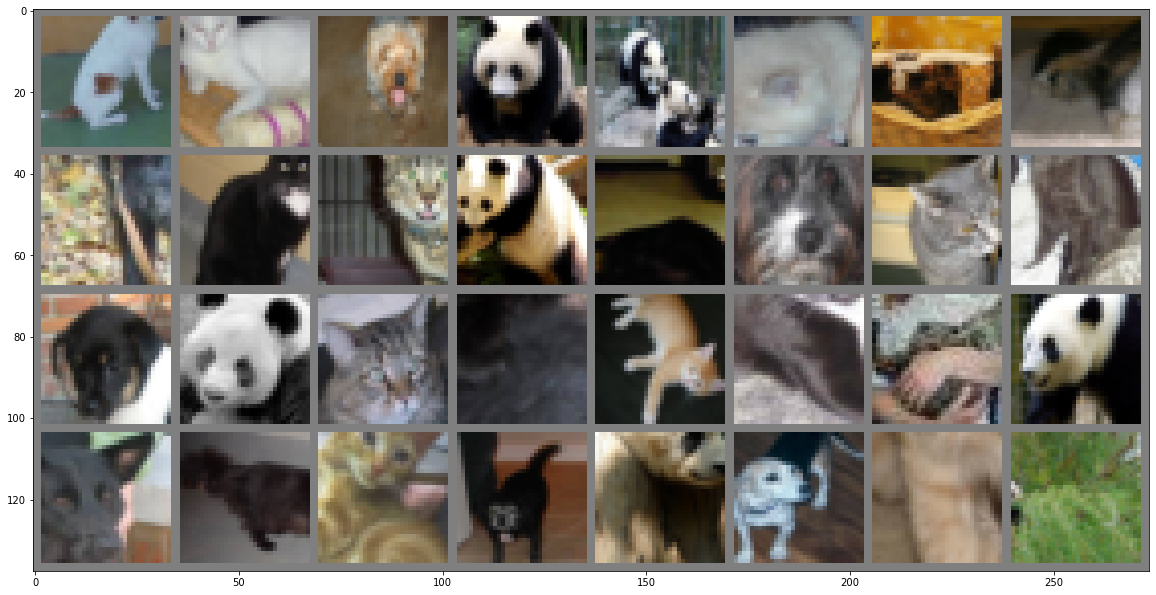

In [3]:
#Show image in a batch
def imgshow(img):
    img = img/2 + 0.5 
    np_img = img.numpy()
    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

    
data_iter = iter(train_load)
img, labels = data_iter.next()
imgshow(torchvision.utils.make_grid(img))

In [4]:
#Define CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        #layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #16

        #layer 2
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #8

        #layer 3
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchnorm5 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU()
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchnorm6 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2) #4

        #FC1
        self.fc1 = nn.Linear(in_features=2048, out_features=1024) #in_features = 128x4x4
        self.batchnorm_fc1 = nn.BatchNorm1d(1024)
        self.relu = nn.ReLU()
        self.dropout_fc1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.batchnorm_fc2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
        self.dropout_fc2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(in_features=256, out_features=64)
        self.batchnorm_fc3 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.dropout_fc3 = nn.Dropout(p=0.5)

        self.fc4 = nn.Linear(in_features=64, out_features=3) #num_classes = 3


    def forward(self, x):
        #layer 1
        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool1(out)

        #layer 2
        out = self.conv3(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.conv4(out)
        out = self.batchnorm4(out)
        out = self.relu(out)
        out = self.maxpool2(out)

        #layer 3
        out = self.conv4(out)
        out = self.batchnorm4(out)
        out = self.relu(out)
        out = self.conv5(out)
        out = self.batchnorm5(out)
        out = self.relu(out)
        out = self.maxpool3(out)
        
        #Flatten()
        out = out.view(-1, 2048)

        #FC 1
        out = self.fc1(out)
        out = self.batchnorm_fc1(out)
        out = self.relu(out)
        out = self.dropout_fc1(out)

        #FC 2
        out = self.fc2(out)
        out = self.batchnorm_fc2(out)
        out = self.relu(out)
        out = self.dropout_fc2(out)

        #FC 3
        out = self.fc3(out)
        out = self.batchnorm_fc3(out)
        out = self.relu(out)
        out = self.dropout_fc3(out)

        #Out
        out = self.fc4(out)

        return out

In [5]:
model = CNN()
model = model.cuda()

#Sumary model
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm5): BatchNorm2d(128

In [6]:
#Using CrossEntropyLoss, optim  use SGD or Adam
loss_f = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)

train_loss = []
val_loss = []
train_acc = []
val_acc = []

#Encoder label
label2id = {
    0: 'Cat',
    1: 'Dog',
    2: 'PanDa'
}

In [7]:
epochs = 64

# Training
for epoch in range(epochs): 
    
    start = time.time()
    
    #Define
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train() #set model on traning mode             
    
    for i, (inputs, labels) in enumerate(train_load, 0):
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        #Convert to Cuda() to use GPU
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()      
        
        #Forward
        outputs = model(inputs)    
        
        #Calculating loss
        loss = loss_f(outputs, labels)  
        iter_loss += loss.item()    
        
        #Backpropagation
        loss.backward()               
        optimizer.step()                
        
        # Record the correct predictions for training data 
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum()
        iterations += 1
    

    train_loss.append(iter_loss/iterations)
    train_acc.append((100 * correct / len(train_set)))
   
    #Eval on validation set
    #Define
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval() #set model on evaluation mode
    
    for i, (inputs, labels) in enumerate(val_load, 0):
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        #To Cuda
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        #Forward and Caculating loss
        outputs = model(inputs)     
        loss = loss_f(outputs, labels) 
        loss += loss.item()
        
        # Record the correct predictions for val data
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum()
        iterations += 1

    val_loss.append(loss/iterations)
    val_acc.append((100 * correct / len(val_set)))

    stop = time.time()
    
    #Display acc, loss on training set and validation set
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Val Loss: {:.3f}, Val Accuracy: {:.3f},,Time: {}s'
           .format(epoch+1, epochs, train_loss[-1], train_acc[-1], val_loss[-1], val_acc[-1],stop-start))

Epoch 1/64, Training Loss: 1.082, Training Accuracy: 47.000, Val Loss: 0.013, Val Accuracy: 55.000,,Time: 10.949060678482056s
Epoch 2/64, Training Loss: 0.905, Training Accuracy: 54.000, Val Loss: 0.044, Val Accuracy: 54.000,,Time: 10.543695449829102s
Epoch 3/64, Training Loss: 0.851, Training Accuracy: 55.000, Val Loss: 0.057, Val Accuracy: 53.000,,Time: 10.592880249023438s
Epoch 4/64, Training Loss: 0.821, Training Accuracy: 55.000, Val Loss: 0.039, Val Accuracy: 58.000,,Time: 10.562042713165283s
Epoch 5/64, Training Loss: 0.824, Training Accuracy: 55.000, Val Loss: 0.020, Val Accuracy: 54.000,,Time: 10.615180015563965s
Epoch 6/64, Training Loss: 0.806, Training Accuracy: 55.000, Val Loss: 0.011, Val Accuracy: 49.000,,Time: 10.555877447128296s
Epoch 7/64, Training Loss: 0.799, Training Accuracy: 57.000, Val Loss: 0.035, Val Accuracy: 56.000,,Time: 10.426510572433472s
Epoch 8/64, Training Loss: 0.785, Training Accuracy: 57.000, Val Loss: 0.013, Val Accuracy: 56.000,,Time: 10.512142658

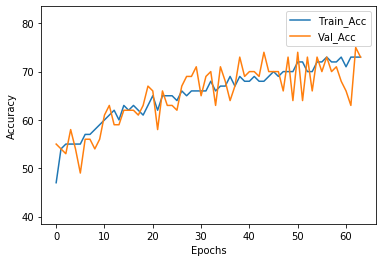

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_acc, label='Train_Acc')
plt.plot(val_acc, label='Val_Acc')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.axis('equal')
plt.legend();


In [9]:
#Save model
torch.save(model.state_dict(),'Animals_Model.pth')

#Can load and continue training model to to improve accuracy
# model.load_state_dict(torch.load('Animals_Model.pth'))

In [10]:
#Define predict
def predict(img_name, model):
    image = cv2.imread(img_name) 
    
    img = Image.fromarray(image)     
    
    img = transform_val(img)    
    img = img.view(1, 3, 32, 32) #resize(32, 32)  
    img = Variable(img)      
    
    model.eval() #set eval mode

    #To Cuda
    model = model.cuda()
    img = img.cuda()

    output = model(img)

#     print(output)
#     print(output.data)
    
    predicted = torch.argmax(output)
    p = label2id[predicted.item()]
    
    #Show origin img and predict
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()

    return  p

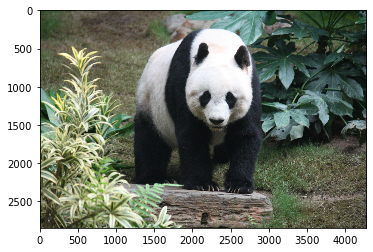

Predict:  PanDa


In [11]:
print('Predict: ', predict('panda_test.jpg', model))